# Notebook 1: Train a Breast Cancer Classifier using Gene Expression Data

## Learning Objectives
- Download and explore RNAseq data from the Cancer Genome Atlas in a SageMaker Studio Notebook.
- Train a classifier using the open-source XGBoost library.

## Environment Notes
This notebook was last tested on a `ml.t3.medium (2 vCPU + 4 GiB)` instance running the `Python 3 (Data Science)` kernel in SageMaker Studio.

## Table of Contents
1. [Background](#1.-Background)
2. [Data Preparation](#2.-Data-Preparation)
    1. [Download and Unzip Data](#2.1.-Download-and-Unzip-Data)
    2. [Load Normalized Gene Expression Data](#2.2.-Load-Normalized-Gene-Expression-Data)
    3. [Load Phenotype Data](#2.3.-Load-Phenotype-Data)
    4. [Merge the Normalized Gene Expression and Phenotype Data](#2.4.-Merge-the-Normalized-Gene-Expression-and-Phenotype-Data)
    5. [Encode Target Variable](#2.5.-Encode-Target-Variable)
    6. [Split the Data into Training-Validation-Test Sets](#2.6.-Split-the-Data-into-Training-Validation-Test-Sets)
3. [Model Training](#3.-Model-Training)
    1. [Train XGBoost Model](#3.1.-Train-XGBoost-Model)
    2. [Evaluate the Model Performance](#3.2.-Evaluate-the-Model-Performance)

## 1. Background

The increase in biological sequence data and development of sophisticated analysis techniques promises to dramatically improve healthcare. The "Central Dogma" of biology claims that the human body operates by transcribing DNA into messenger RNA, which is then translated into proteins. Each step in this process is managed by sequence information. So, the hope of bioinformatics is to decode these sequences and provide insight into their effect and possible alteration.

![alt text](img/640px-Gene_structure_eukaryote_2_annotated.png "Central Dogma")

*The structure and expression of a eukaryotic protein-coding gene. WikiJournal of Medicine 4 (1). DOI:10.15347/wjm/2017.002. ISSN 20024436. [(Wikimedia Commons)](https://commons.wikimedia.org/wiki/File:Gene_structure_eukaryote_2_annotated.svg)*

One of the more recent advances in sequence analysis is RNA sequencing (RNAseq). By using high-throughput sequencers, scientists can now capture a "snapshot" of what mRNA is present in a sample, and thus what genes are expressed, at any given time. RNAseq does not require prior knowledge of what genes to target and can capture alternatively-spliced variants which have been shown to have a significant impact on disease.

In this notebook, we'll demonstrate using RNAseq data from the [Cancer Genome Atlas](https://www.nature.com/articles/nature11412) to predict HER2 status, a binary classification task. Breast cancers cells that overexpress the HER2 receptor[(HER2+)](https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/breast-cancer-her2-status.html) are responsive to HER2-directed therapies like Herceptin.

![alt text](img/overexpression.png "HER2 Overexpression")

These targeted therapies have significantly improved the survival rate of HER2+ breast cancer patients.

![alt text](img/brca_stats.png "Breast cancer statistics")

## 2. Data Preparation

In this step, we download and combine two datasets from the [UCSC Xena platform](http://xena.ucsc.edu/), based on [The Cancer Genome Atlas](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga):

* [Normalized Gene Expression Data (1,218 samples)](https://xenabrowser.net/datapages/?dataset=TCGA.BRCA.sampleMap%2FHiSeqV2_PANCAN&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443): TCGA breast invasive carcinoma (BRCA) gene expression data measured experimentally using the IlluminaHiSeq RNAseq platform, mean-normalized (per gene) across all TCGA cohorts. Values in this dataset are generated at UCSC by combining gene expression RNAseq values of all TCGA cohorts. Values for each gene are then mean-centered per gene the data split back into cohorts.

* [Phenotypes (1,247 samples)](https://xenabrowser.net/datapages/?dataset=TCGA.BRCA.sampleMap%2FBRCA_clinicalMatrix&host=https%3A%2F%2Ftcga.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443): TCGA breast invasive carcinoma (BRCA) clinically-observed phenotypes.

### 2.1. Import Libraries

In [ ]:
%pip install --disable-pip-version-check -U -q 'xgboost==2.1.0'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score
import xgboost as xgb

# Define working directories
WORKING_DIR = os.getcwd()
DATA_DIR = os.path.join(WORKING_DIR, "data")
print(f"Working directory is {WORKING_DIR}")
print(f"Data directory is {DATA_DIR}")

HISEQ_URI = "https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/HiSeqV2_PANCAN.gz"
BRCA_CLINICAL_MATRIX_URI = (
    "https://tcga.xenahubs.net/download/TCGA.BRCA.sampleMap/BRCA_clinicalMatrix"
)

Working directory is /root/aws-healthcare-lifescience-ai-ml-sample-notebooks/workshops/RNAseq_Tertiary_Analysis
Data directory is /root/aws-healthcare-lifescience-ai-ml-sample-notebooks/workshops/RNAseq_Tertiary_Analysis/data


### 2.2. Load Normalized Gene Expression Data

In [4]:
# Read in RNAseq data file
genom = pd.read_csv(HISEQ_URI, compression="gzip", sep="\t")

print(
    f"The gene expression data has {genom.shape[0]} records (genes) and {genom.shape[1]} columns (samples)\n"
)

# Extract list of sample identifiers
genom_identifiers = genom["sample"].values.tolist()

# Print the first few records
print("Example gene expression data:")
genom.head(3)

The gene expression data has 20530 records (genes) and 1219 columns (samples)

Example gene expression data:


,sample,TCGA-AR-A5QQ-01,TCGA-D8-A1JA-01,TCGA-BH-A0BQ-01,TCGA-BH-A0BT-01,TCGA-A8-A06X-01,TCGA-A8-A096-01,TCGA-BH-A0C7-01,TCGA-AC-A5XU-01,TCGA-PE-A5DE-01,...,TCGA-A7-A13E-11,TCGA-C8-A8HP-01,TCGA-E9-A5FL-01,TCGA-AC-A2FB-11,TCGA-E2-A15F-01,TCGA-A2-A3XT-01,TCGA-B6-A0X7-01,TCGA-BH-A1EV-11,TCGA-3C-AALJ-01,TCGA-B6-A0X1-01
0,ARHGEF10L,-0.356592,-2.429392,-0.542392,-0.844192,-0.222292,-0.097492,0.229108,-0.711592,0.075808,...,-0.237492,0.318608,0.055908,0.045008,0.169408,1.650408,0.710508,-0.459192,1.082808,0.452408
1,HIF3A,-3.976026,-1.894026,-2.832326,-4.213326,-4.972826,-5.280926,-1.945726,-5.080926,-2.616926,...,2.599874,-3.338826,-1.690226,2.632474,-4.671126,-4.237826,-1.485126,1.698974,-4.623726,-3.135626
2,RNF17,-0.531035,0.093465,0.021565,-0.531035,-0.531035,0.345465,-0.531035,-0.531035,-0.531035,...,-0.531035,-0.531035,3.199465,-0.531035,-0.531035,0.601865,-0.105235,-0.531035,-0.531035,-0.531035


### 2.3. Load Phenotype Data

In [5]:
phenotypes = pd.read_csv(BRCA_CLINICAL_MATRIX_URI, sep="\t")
print(
    f"The phenotype data has {phenotypes.shape[0]} records (samples) and {phenotypes.shape[1]} columns (phenotypes).\n"
)

# Print the first few records
print("Example phenotype data:")
phenotypes.loc[[0, 100, 200, 300, 400, 500]]

The phenotype data has 1247 records (samples) and 194 columns (phenotypes).

Example phenotype data:


,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,NaN,TCGA-3C-AAAU-01A-11D-A41E-01,TCGA-3C-AAAU-01,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,TCGA-3C-AAAU-01A-11D-A41E-01,NaN
100,TCGA-A2-A25A-01,Stage IIA,44.0,2.0,Stage IIA,2968.0,NaN,Positive,FEMALE,Negative,...,TCGA-A2-A25A-01A-12D-A16D-09,NaN,50c720f4-dbcb-4b8b-9808-d130f5197d27,NaN,TCGA-A2-A25A-01A-12D-A16C-01,TCGA-A2-A25A-01,NaN,50c720f4-dbcb-4b8b-9808-d130f5197d27,TCGA-A2-A25A-01A-12D-A16C-01,NaN
200,TCGA-A8-A07P-01,Stage IIB,68.0,4.0,Stage IIB,334.0,NaN,Positive,FEMALE,Positive,...,TCGA-A8-A07P-01A-11W-A019-09,TCGA-A8-A07P-01,dad4f72e-cb2c-4015-af6a-53ad0ae45f12,TCGA-A8-A07P-01,TCGA-A8-A07P-01A-11D-A011-01,NaN,TCGA-A8-A07P-01A-11R-A00Z-07,dad4f72e-cb2c-4015-af6a-53ad0ae45f12,TCGA-A8-A07P-01A-11D-A011-01,TCGA-A8-A07P-01
300,TCGA-AC-A5XS-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,b713b36d-44c7-41ed-82a5-762322472a56,NaN,TCGA-AC-A5XS-01A-11D-A29M-01,TCGA-AC-A5XS-01,NaN,b713b36d-44c7-41ed-82a5-762322472a56,TCGA-AC-A5XS-01A-11D-A29M-01,NaN
400,TCGA-AO-A1KQ-01,Stage IIIB,84.0,4.0,Stage IIIB,1519.0,NaN,Positive,MALE,Negative,...,NaN,NaN,204a78d9-67aa-4e49-b285-bbb25c6ed142,NaN,TCGA-AO-A1KQ-01A-11D-A13J-01,TCGA-AO-A1KQ-01,NaN,204a78d9-67aa-4e49-b285-bbb25c6ed142,TCGA-AO-A1KQ-01A-11D-A13J-01,NaN
500,TCGA-B6-A0IP-01,Stage IA,74.0,2.0,Stage I,3374.0,NaN,Positive,FEMALE,Negative,...,TCGA-B6-A0IP-01A-11D-A045-09,TCGA-B6-A0IP-01,9384eb09-5787-49e8-b07e-bd9f71997771,TCGA-B6-A0IP-01,TCGA-B6-A0IP-01A-11D-A036-01,NaN,TCGA-B6-A0IP-01A-11R-A034-07,9384eb09-5787-49e8-b07e-bd9f71997771,TCGA-B6-A0IP-01A-11D-A036-01,TCGA-B6-A0IP-01


There are a lot of potential phenotypic values to choose as targets. For this example, let's focus our attention on `HER2_Final_Status_nature2012`.

Let's replace any missing HER2 values with `Negative`

In [6]:
phenotypes_subset = phenotypes[
    ["sampleID", "HER2_Final_Status_nature2012"]
].reset_index(drop=True)
print(
    f"Of the {phenotypes_subset.shape[0]} records, only {phenotypes_subset.dropna().shape[0]} have complete HER2 values. Let's replace the missing values with 'Negative'.\n"
)

phenotypes_subset.fillna("Negative", inplace=True)
print("Example phenotype data:")
phenotypes_subset.head(10)

Of the 1247 records, only 776 have complete HER2 values. Let's replace the missing values with 'Negative'.

Example phenotype data:


,sampleID,HER2_Final_Status_nature2012
0,TCGA-3C-AAAU-01,Negative
1,TCGA-3C-AALI-01,Negative
2,TCGA-3C-AALJ-01,Negative
3,TCGA-3C-AALK-01,Negative
4,TCGA-4H-AAAK-01,Negative
5,TCGA-5L-AAT0-01,Negative
6,TCGA-5L-AAT1-01,Negative
7,TCGA-5T-A9QA-01,Negative
8,TCGA-A1-A0SB-01,Negative
9,TCGA-A1-A0SD-01,Negative


### 2.4. Merge the Normalized Gene Expression and Phenotype Data

The gene expression and phenotype data are oriented in different directions, so let's transpose the former before we merge them together.

In [7]:
genom_transpose = (
    genom.set_index("sample")
    .transpose()
    .reset_index()
    .rename(columns={"index": "sampleID"})
)
print(
    f"Transposing the gene expression data changes its shape from {genom.shape[0]} x {genom.shape[1]} to {genom_transpose.shape[0]} x {genom_transpose.shape[1]}.\n"
)

# Merge the phenotype data with the transposed gene expression data on `sampleID`
df = pd.merge(phenotypes_subset, genom_transpose, on="sampleID", how="outer")
print(
    f"The merged data set has {df.shape[0]} records (samples) and {df.shape[1]} columns (features).\n"
)

# Let's look at the results for 6 specific samples.
print("Example transposed gene expression data:")
df.loc[[0, 100, 200, 300, 400, 500]]

Transposing the gene expression data changes its shape from 20530 x 1219 to 1218 x 20531.

The merged data set has 1247 records (samples) and 20532 columns (features).

Example transposed gene expression data:


,sampleID,HER2_Final_Status_nature2012,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,TCGA-3C-AAAU-01,Negative,0.607308,-3.194126,-0.531035,-0.145872,0.237422,-0.29921,-0.142694,-0.217446,...,-0.748878,0.565583,-0.767233,-1.28139,-0.271377,-0.492286,0.360373,1.067905,0.076267,-0.392212
100,TCGA-A2-A25A-01,Negative,-0.109892,-0.079726,-0.531035,0.105228,0.586722,0.21839,-0.145994,1.731154,...,0.181522,6.125683,0.576567,-1.28139,0.292723,1.339014,2.594573,-0.261095,4.387167,-0.410412
200,TCGA-A8-A07P-01,Positive,-0.826392,-4.528526,-0.531035,0.107628,0.959022,0.89679,-0.122094,-0.307246,...,0.277322,-1.159017,-0.127633,-1.28139,-0.828377,-0.147486,0.273573,-0.423495,0.525567,0.659688
300,TCGA-AC-A5XS-01,Negative,-0.539492,-2.258026,-0.531035,0.204328,0.217822,-0.10851,-0.308394,0.062654,...,-0.748878,-1.036717,0.422667,0.23371,-1.242977,0.611014,1.230373,0.490305,2.490267,0.780188
400,TCGA-AO-A1KQ-01,Negative,-0.758592,-4.253926,-0.531035,0.079928,-0.135978,-0.13821,0.167806,0.318054,...,-0.175578,3.133683,0.397967,-0.29899,0.775423,-0.184586,-0.285527,0.371905,-0.202533,0.864788
500,TCGA-B6-A0IP-01,Negative,0.716208,-3.858326,0.110665,0.566228,0.429122,-0.30791,0.490806,-0.154446,...,0.131022,2.346983,-0.540533,-1.28139,-0.022677,0.020714,0.318873,0.427305,2.008267,-0.012512


### 2.5. Encode Target Variable

In [8]:
df["target"] = [0 if t == "Negative" else 1 for t in df["HER2_Final_Status_nature2012"]]
df.insert(loc=1, column="target", value=df.pop("target"))

# Drop any rows with NaN values
df = df.dropna()

# Remove the original target values and sample IDs to avoid data leakage
df = df.drop(["HER2_Final_Status_nature2012", "sampleID"], axis=1)

df.loc[[0, 100, 200, 300, 400, 500]]

,target,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,0,0.607308,-3.194126,-0.531035,-0.145872,0.237422,-0.29921,-0.142694,-0.217446,0.333001,...,-0.748878,0.565583,-0.767233,-1.28139,-0.271377,-0.492286,0.360373,1.067905,0.076267,-0.392212
100,0,-0.109892,-0.079726,-0.531035,0.105228,0.586722,0.21839,-0.145994,1.731154,-0.128999,...,0.181522,6.125683,0.576567,-1.28139,0.292723,1.339014,2.594573,-0.261095,4.387167,-0.410412
200,1,-0.826392,-4.528526,-0.531035,0.107628,0.959022,0.89679,-0.122094,-0.307246,-0.423399,...,0.277322,-1.159017,-0.127633,-1.28139,-0.828377,-0.147486,0.273573,-0.423495,0.525567,0.659688
300,0,-0.539492,-2.258026,-0.531035,0.204328,0.217822,-0.10851,-0.308394,0.062654,-0.423399,...,-0.748878,-1.036717,0.422667,0.23371,-1.242977,0.611014,1.230373,0.490305,2.490267,0.780188
400,0,-0.758592,-4.253926,-0.531035,0.079928,-0.135978,-0.13821,0.167806,0.318054,0.149901,...,-0.175578,3.133683,0.397967,-0.29899,0.775423,-0.184586,-0.285527,0.371905,-0.202533,0.864788
500,0,0.716208,-3.858326,0.110665,0.566228,0.429122,-0.30791,0.490806,-0.154446,-0.423399,...,0.131022,2.346983,-0.540533,-1.28139,-0.022677,0.020714,0.318873,0.427305,2.008267,-0.012512


What's the distribution between our positive and negative classes?

In [9]:
from collections import Counter

print("How many of the samples are positive for HER2?")
print(df.target.value_counts())

# count examples in each class to estimate scale_pos_weight value
counter = Counter(df.target)
scale_pos_weight = counter[0] / counter[1]
print(f"Ratio of positive to negative classes is {scale_pos_weight}")

How many of the samples are positive for HER2?
0    1094
1     124
Name: target, dtype: int64
Ratio of positive to negative classes is 8.82258064516129


Finally, let's review the transformed test data.

In [10]:
df

,target,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
0,0,0.607308,-3.194126,-0.531035,-0.145872,0.237422,-0.29921,-0.142694,-0.217446,0.333001,...,-0.748878,0.565583,-0.767233,-1.28139,-0.271377,-0.492286,0.360373,1.067905,0.076267,-0.392212
1,0,-0.641192,-4.928226,0.095465,0.098128,-0.541978,-0.32291,-0.044694,-0.148846,1.841601,...,0.312922,0.079683,0.475267,1.99661,0.161423,0.273714,0.644673,-0.428695,0.068667,-0.043812
2,0,1.082808,-4.623726,-0.531035,0.484028,-0.183678,-0.91901,0.261106,0.687754,-0.423399,...,-0.748878,-0.656117,-0.216733,0.21081,0.101023,0.660514,1.295073,0.915105,0.168567,0.047788
3,0,0.121608,-2.881526,-0.531035,0.179128,0.039222,-0.45491,0.180306,0.775554,-0.423399,...,0.415422,-0.178417,-0.211233,-1.28139,0.108023,1.132814,0.496773,0.240105,3.099767,0.112888
4,0,0.420208,-3.282726,-0.531035,-0.020972,-0.117978,-0.55781,-0.173794,-1.079146,0.465001,...,0.685222,-0.698717,-0.484233,-1.28139,-0.223577,1.222714,0.225573,-0.301995,0.200067,-0.080212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,0,-0.773692,-2.644726,-0.531035,0.488228,-0.590378,-0.59251,0.362106,-1.204246,-0.423399,...,-0.748878,-1.587117,-0.582533,-1.28139,-0.249077,1.563914,0.301273,0.875205,0.017067,0.010088
1242,0,0.084408,-0.247926,1.218365,-0.027072,-0.127378,-0.21191,0.186506,0.470154,-0.423399,...,-0.269978,1.280583,0.419667,-1.28139,0.078423,0.900214,1.257373,0.102805,3.509567,-0.204612
1244,0,0.671508,0.051374,-0.531035,0.377328,-0.157278,-0.51971,-0.044694,0.439754,-0.423399,...,0.210622,2.919383,0.655067,1.96691,0.208423,1.533414,1.303673,-0.401595,2.575167,0.121288
1245,0,0.291708,-3.024026,-0.531035,0.250428,-0.155478,-0.52061,0.016906,2.759954,-0.423399,...,-0.073278,-0.105817,1.743967,-1.28139,-0.564277,1.163114,0.943373,1.107905,3.656867,0.255488


### 2.6. Split the Data into Training-Validation-Test Sets

In [11]:
# Hold out 20% of the data for testing
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["target"])

# Hold out an additional 20% of the training data for validaton
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["target"]
)

# Convert labels and features into DMatrix objects for XGBoost
train_labels = train_df.pop("target")
validation_labels = val_df.pop("target")
test_labels = test_df.pop("target")

dtrain = xgb.DMatrix(data=train_df, label=train_labels)
dval = xgb.DMatrix(data=val_df, label=validation_labels)
dtest = xgb.DMatrix(data=test_df, label=test_labels)

print(
    f"The training data has {train_df.shape[0]} records and {train_df.shape[1]} columns."
)
print(
    f"The validation data has {val_df.shape[0]} records and {val_df.shape[1]} columns."
)
print(f"The test data has {test_df.shape[0]} records and {test_df.shape[1]} columns.")

The training data has 779 records and 20530 columns.
The validation data has 195 records and 20530 columns.
The test data has 244 records and 20530 columns.


## 3. Model Training

### 3.1. Train XGBoost Model

In [12]:
hyper_params_dict = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "error",
    "max_depth": 3,
    "min_child_weight": 5,
    "subsample": 0.9,
    "verbosity": 1,
    "tree_method": "auto",
    "predictor": "auto",
    "scale_pos_weight": scale_pos_weight,
}

evals_result = {}
booster = xgb.train(
    params=hyper_params_dict,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dval, "validation")],
    num_boost_round=15,
    evals_result=evals_result,
)

[0]	train-error:0.06418	validation-error:0.12821
[1]	train-error:0.02953	validation-error:0.09744
[2]	train-error:0.02953	validation-error:0.08718
[3]	train-error:0.01540	validation-error:0.08205
[4]	train-error:0.01284	validation-error:0.08718
[5]	train-error:0.01155	validation-error:0.08718
[6]	train-error:0.00513	validation-error:0.08205
[7]	train-error:0.00642	validation-error:0.08718
[8]	train-error:0.00257	validation-error:0.08205
[9]	train-error:0.00385	validation-error:0.07692
[10]	train-error:0.00385	validation-error:0.08205
[11]	train-error:0.00128	validation-error:0.08205
[12]	train-error:0.00257	validation-error:0.07692
[13]	train-error:0.00128	validation-error:0.07692
[14]	train-error:0.00128	validation-error:0.07692


### 3.2. Evaluate the Model Performance

Plot learning curves

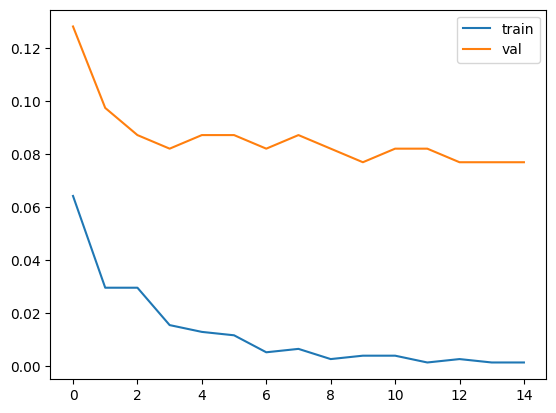

In [13]:
plt.plot(evals_result["train"]["error"], label="train")
plt.plot(evals_result["validation"]["error"], label="val")
plt.legend()
plt.show()

This is pretty good, but it does seem like we're hitting some bias. Next, we'll evaluate model accuracy on test data.

Evaluate predictions

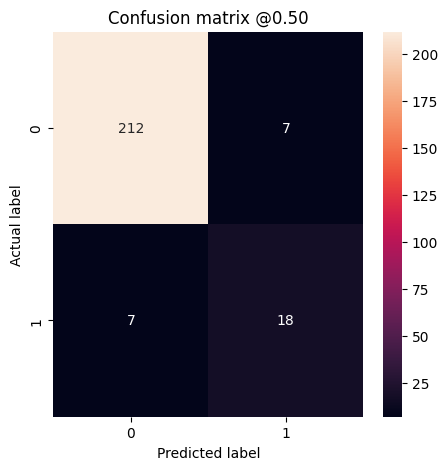

Correctly un-detected (True Negatives):  212
Incorrectly detected (False Positives):  7
Misses (False Negatives):  7
Hits (True Positives):  18
Total:  25
Accuracy: 0.94
Precision: 0.72
F1 Score: 0.72


In [14]:
test_predictions = booster.predict(dtest)
accuracy = accuracy_score(test_labels, np.rint(test_predictions))
accuracy = accuracy_score(test_labels, np.rint(test_predictions))
precision = precision_score(test_labels, np.rint(test_predictions))
f1 = f1_score(test_labels, np.rint(test_predictions))

p = 0.5
cm = confusion_matrix(test_labels, np.array(test_predictions) > p)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix @{:.2f}".format(p))
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()

if len(set(list(test_labels))) == 2:
    print("Correctly un-detected (True Negatives): ", cm[0][0])
    print("Incorrectly detected (False Positives): ", cm[0][1])
    print("Misses (False Negatives): ", cm[1][0])
    print("Hits (True Positives): ", cm[1][1])
    print("Total: ", np.sum(cm[1]))

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

In the next notebook, we'll look at some SageMaker features to improve the cost and performance of this process.